In [1]:
import glob
import wandb
import fasttext
import numpy as np
import pandas as pd
from rich import print
from pathlib import Path
from tqdm.auto import tqdm
from dotenv import load_dotenv
from collections import defaultdict
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report,
                             ConfusionMatrixDisplay)

In [2]:
sns.set_theme(context='notebook', style='dark')
tqdm.pandas()

In [3]:
load_dotenv()
wandb.login()

wandb: Currently logged in as: e_hossam96. Use `wandb login --relogin` to force relogin


True

In [4]:
# wandb configs
PROJECT_NAME = 'ARABIC_DISAMBIGUATION_STUDY'
JOB_TYPE = 'MODELING'
TAGS = ['MODELING', 'BASELINE', 'LOGISTIC_REGRESSION']
NOTES = 'Baseline modeling using Logistic Regression'
RUN_NAME = 'Logistic_Regression_Baseline_Modeling'
config = defaultdict(dict)

In [5]:
seed = 42
fasttext_model_path = '../models/cc.ar.300.bin'
to_use_artifact_name = 'Sentiment-Classification-Dataset:latest'

In [6]:
run = wandb.init(project=PROJECT_NAME, job_type=JOB_TYPE,
                 name=RUN_NAME, notes=NOTES, tags=TAGS, config=config)

In [7]:
data_artifact = run.use_artifact(to_use_artifact_name)

In [8]:
data_path = data_artifact.download(
    root=Path(f'../data/{to_use_artifact_name}'))

wandb:   3 of 3 files downloaded.  


In [9]:
data_path = Path(data_path)

In [10]:
data_dict = {}
for f in glob.glob(f'{str(data_path)}/*'):
    data_dict[f.split('/')[-1]] = pd.read_csv(f)

In [11]:
data_dict['train'].head(2)

,tweet,label,text,text_arabert
0,تعلن #وزارة_الصحة عن تأكيد إصابة 530 حالة، وتس...,neutral,تعلن وزارة الصحة عن تأكيد إصابة 530 حالة، وتسج...,تعلن وزار +ة ال+ صح +ة عن تأكيد إصاب +ة 530 حا...
1,موجز إعلامي حول فيروس كورونا المستجد COVID-19 ...,neutral,موجز إعلامي حول فيروس كورونا المستجد COVID-19 ...,موجز إعلامي حول فيروس كورونا ال+ مستجد COVID -...


In [12]:
encoder = fasttext.load_model(fasttext_model_path)

In [13]:
label_names = data_dict['train'].label.unique()
label_names

array(['neutral', 'negative', 'positive'], dtype=object)

In [14]:
label2id = {label_names[i]: i for i in range(len(label_names))}
id2label = {i: label_names[i] for i in range(len(label_names))}

In [15]:
for n, d in data_dict.items():
    data_dict[n]['vectors'] = d.text.progress_apply(
        encoder.get_sentence_vector)
    data_dict[n]['label_id'] = d.label.apply(lambda x: label2id[x])

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [16]:
del encoder

In [17]:
data_dict['train'].head(2)

,tweet,label,text,text_arabert,vectors,label_id
0,تعلن #وزارة_الصحة عن تأكيد إصابة 530 حالة، وتس...,neutral,تعلن وزارة الصحة عن تأكيد إصابة 530 حالة، وتسج...,تعلن وزار +ة ال+ صح +ة عن تأكيد إصاب +ة 530 حا...,"[0.029239306, -0.010979053, -0.0070109456, 0.0...",0
1,موجز إعلامي حول فيروس كورونا المستجد COVID-19 ...,neutral,موجز إعلامي حول فيروس كورونا المستجد COVID-19 ...,موجز إعلامي حول فيروس كورونا ال+ مستجد COVID -...,"[0.029317467, -0.0035008627, -0.0065403106, 0....",0


In [18]:
class_weights = data_dict['train'].label_id.value_counts(
    normalize=True).to_dict()
class_weights

{0: 0.863125, 1: 0.093, 2: 0.043875}

In [19]:
model = LogisticRegression(class_weight=class_weights,
                           max_iter=int(1e3), random_state=seed, C=1.0)

In [20]:
model.fit(data_dict['train'].vectors.to_list(),
          data_dict['train'].label_id.to_list())

LogisticRegression(class_weight={0: 0.863125, 1: 0.093, 2: 0.043875},
                   max_iter=1000, random_state=42)

In [21]:
X_test = data_dict['test'].vectors.to_list()
y_true = data_dict['test'].label_id.to_list()
y_prob = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [22]:
print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

/home/hossam/miniconda3/envs/disambg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hossam/miniconda3/envs/disambg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hossam/miniconda3/envs/disambg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

precision    recall  f1-score   support

     neutral     0.8630    1.0000    0.9265      1726
    negative     0.0000    0.0000    0.0000       186
    positive     0.0000    0.0000    0.0000        88

    accuracy                         0.8630      2000
   macro avg     0.2877    0.3333    0.3088      2000
weighted avg     0.7448    0.8630    0.7995      2000

In [23]:
summary = {}

summary['test_f1'] = f1_score(y_true, y_pred, average='macro')
summary['test_precision'] = precision_score(y_true, y_pred, average='macro')
summary['test_recall'] = recall_score(y_true, y_pred, average='macro')
summary

/home/hossam/miniconda3/envs/disambg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'test_f1': 0.3088208981928789,
 'test_precision': 0.2876666666666667,
 'test_recall': 0.3333333333333333}

In [24]:
for k, v in summary.items():
    run.summary[k] = v

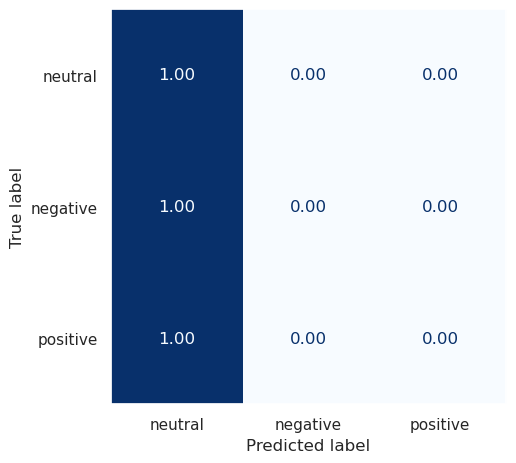

In [25]:
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

fig, ax = plt.subplots()
ax.grid(False)
disp.plot(cmap="Blues", colorbar=False, ax=ax, values_format='.2f')
plt.tight_layout()
plt.show()

In [26]:
run.log({'Test Confusion Matrix': wandb.plot.confusion_matrix(
    y_true=y_true, preds=y_pred, class_names=label_names)})

In [27]:
run.finish()

test_f1,0.30882
test_precision,0.28767
test_recall,0.33333
